# ResNet34 Architecture

In [1]:
import torch
import torch.nn as nn

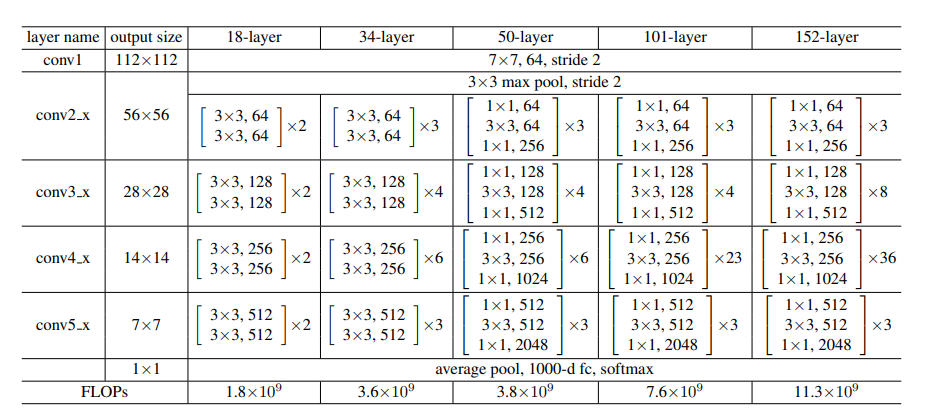

In [2]:
class block(nn.Module):
  # Identity downsample for conv layer for projection shortcut
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(block,self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.relu = nn.ReLU()

    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

In [3]:
class ResNet(nn.Module):
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64 # Since, in resnet the input channel starts from 64

    # For Conv1 (image_channels in start is 3(RGB) --> after conv layer 64)
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()

    # For Maxpool (channel 64 remains constant, spatial dimension decreases in half)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet layers (In ResNet34, there are 4 layers where, in each layer the blocks are repeated [3,4,6,3] times)
    self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
    self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
    self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

    # For Avg. Pooling such that the output is 512x1x1 so Adaptive Pooling applied accordingly
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    # For final fully connected layer
    self.fc = nn.Linear(512*1*1, num_classes)

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc(x)
    return x

  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride!=1:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, kernel_size=1,
                                                    stride=stride),
                                          nn.BatchNorm2d(out_channels))

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

In [4]:
def ResNet34(image_channels=3, num_classes=1000):
  return ResNet(block, [3,4,6,3], image_channels, num_classes)

In [5]:
# Instantiate ResNet34
model = ResNet34()

In [6]:
# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Model summary to compare params
from torchsummary import summary

summary(model.to(device), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
            block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

From the original paper, ResNet34 model is said to have around 21M parameters which matches the model we created.

In [8]:
# Validating the model with example (1 image with shape=3x224x224)
x = torch.randn(5, 3, 224, 224)
model.to(device)(x.to(device)).shape

torch.Size([5, 1000])

# Load CIFAR-10 dataset

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations to apply to the CIFAR-10 data
transform = transforms.Compose([transforms.Resize((224,224)), #<-- Resize for ResNet input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Download and load train and test data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 49050036.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [11]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

The training set has 50000 images whereas, test set has 10000 images.


In [12]:
# The classes in the dataset
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

torch.Size([3, 224, 224]) 3
Label:  cat (3)


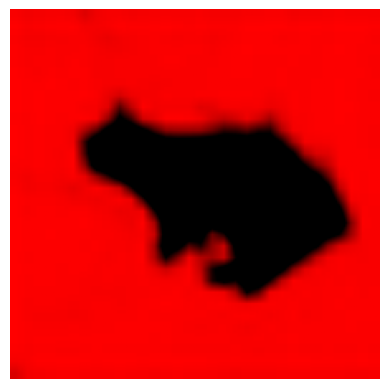

In [13]:
# Let's visualize the 22nd image in the train_dataset
feature, label = train_dataset[21]
print(feature.shape, label)

import matplotlib.pyplot as plt

# Permute the image tensor from 3x224x224 to 224x224x3
image = torch.permute(feature, (1, 2, 0))

# Display the image
plt.imshow(image)
print('Label: ', train_dataset.classes[label], "("+str(label)+")")
plt.axis('off') # To remove axis label
plt.show()

# DataLoader for Train-Test Dataset

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [15]:
# Example from train_loader
train_iterate = iter(train_loader)
features, labels = next(train_iterate)
features.shape

torch.Size([64, 3, 224, 224])

In [16]:
labels

tensor([9, 6, 4, 3, 5, 7, 6, 5, 4, 0, 4, 2, 1, 7, 0, 9, 7, 8, 5, 0, 0, 4, 0, 6,
        1, 1, 7, 2, 8, 9, 8, 8, 7, 7, 5, 3, 8, 7, 5, 9, 0, 5, 3, 1, 6, 4, 2, 0,
        7, 2, 8, 6, 0, 7, 3, 0, 7, 8, 2, 8, 9, 1, 7, 5])

# Create Overfit Data
The dataset contains only 2 images of 5 classes -- 10 images in total.

In [17]:
# New list to store final dataset
custom_dataset = [train_dataset[1], train_dataset[3], train_dataset[4], train_dataset[5], train_dataset[6], train_dataset[13], train_dataset[14], train_dataset[20], train_dataset[29], train_dataset[30]]

In [18]:
len(custom_dataset)

10

In [19]:
# Extracting image and label of 10th image
feature_custom, label_custom = custom_dataset[9]

In [20]:
feature_custom, label_custom

(tensor([[[-0.0118, -0.0118, -0.0118,  ..., -0.0824, -0.0824, -0.0824],
          [-0.0118, -0.0118, -0.0118,  ..., -0.0824, -0.0824, -0.0824],
          [-0.0118, -0.0118, -0.0118,  ..., -0.0824, -0.0824, -0.0824],
          ...,
          [-0.0353, -0.0353, -0.0353,  ..., -0.0510, -0.0510, -0.0510],
          [-0.0353, -0.0353, -0.0353,  ..., -0.0510, -0.0510, -0.0510],
          [-0.0353, -0.0353, -0.0353,  ..., -0.0510, -0.0510, -0.0510]],
 
         [[-0.0745, -0.0745, -0.0745,  ..., -0.1294, -0.1294, -0.1294],
          [-0.0745, -0.0745, -0.0745,  ..., -0.1294, -0.1294, -0.1294],
          [-0.0745, -0.0745, -0.0745,  ..., -0.1294, -0.1294, -0.1294],
          ...,
          [-0.0980, -0.0980, -0.0980,  ..., -0.1137, -0.1137, -0.1137],
          [-0.0980, -0.0980, -0.0980,  ..., -0.1137, -0.1137, -0.1137],
          [-0.0980, -0.0980, -0.0980,  ..., -0.1137, -0.1137, -0.1137]],
 
         [[-0.1373, -0.1373, -0.1373,  ..., -0.2235, -0.2235, -0.2235],
          [-0.1373, -0.1373,

Label:  airplane (0)


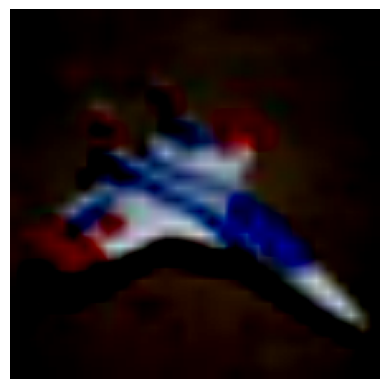

In [21]:
# Let's visualize the first image in the custom_dataset
import matplotlib.pyplot as plt

# Permute the image tensor from 3x224x224 to 224x224x3
image = torch.permute(feature_custom, (1, 2, 0))

# Display the image
plt.imshow(image)
print('Label: ', train_dataset.classes[label_custom], "("+str(label_custom)+")")
plt.axis('off') # To remove axis label
plt.show()

In [22]:
from torch.utils.data import Dataset

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        return image, label

In [23]:
# Create an instance of the custom dataset
overfit = CustomDataset(custom_dataset)

In [24]:
# Len of overfit
len(overfit)

10

In [25]:
# Create DataLoader for overfit data
overfit_loader = torch.utils.data.DataLoader(overfit, batch_size=1, shuffle=True)

In [26]:
# Example checking the overfit_loader
of_iter = iter(overfit_loader)
of_feature, of_label = next(of_iter)
of_feature.shape

torch.Size([1, 3, 224, 224])

# Training and Validating with Overfit Data

In [27]:
# Instantiate the model
overfit_model = ResNet34(num_classes=10)

In [28]:
# Model summary to validate the categorized class
from torchsummary import summary

summary(overfit_model.to(device), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
            block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [29]:
# Compile tha model
import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(overfit_model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [30]:
from tqdm import tqdm
import time

history_loss = [] # To plot the epoch vs. loss
history_acc = [] # To plot the epoch vs. accuracy

for epoch in tqdm(range(100), desc='Epochs'):

  overfit_model.train()

  start_time = time.time() # Start time of the epoch

  running_loss = 0.0
  running_corrects = 0

  # Iterate over the training data in batches
  for inputs, labels in overfit_loader:
      # Move the inputs and labels to the selected device
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = overfit_model(inputs)
      torch.cuda.empty_cache() # Limit GPU memory growth

      # Calculate the loss
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      torch.cuda.empty_cache() # Limit GPU memory growth

      # Update running loss and accuracy
      running_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)

  end_time = time.time()  # End time of the epoch
  epoch_duration = end_time - start_time  # Duration of the epoch

  # Calculate epoch loss and accuracy for training data
  epoch_loss = running_loss / len(overfit)
  epoch_acc = running_corrects.double() / len(overfit)

  history_loss.append(epoch_loss)
  history_acc.append(epoch_acc)

  if (epoch+1) % 10 == 0:
    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Print the loss and accuracy for overfit data
    print(f"Epoch [{epoch+1}/{100}], "
          f"Overfit Loss: {epoch_loss:.4f}, Overfit Accuracy: {epoch_acc:.4f}")


Epochs:  10%|█         | 10/100 [00:04<00:29,  3.04it/s]

Epoch 10 completed in 0.31 seconds
Epoch [10/100], Overfit Loss: 1.5093, Overfit Accuracy: 0.1000


Epochs:  20%|██        | 20/100 [00:07<00:25,  3.15it/s]

Epoch 20 completed in 0.31 seconds
Epoch [20/100], Overfit Loss: 0.2166, Overfit Accuracy: 1.0000


Epochs:  30%|███       | 30/100 [00:10<00:22,  3.10it/s]

Epoch 30 completed in 0.32 seconds
Epoch [30/100], Overfit Loss: 0.0211, Overfit Accuracy: 1.0000


Epochs:  40%|████      | 40/100 [00:14<00:19,  3.04it/s]

Epoch 40 completed in 0.31 seconds
Epoch [40/100], Overfit Loss: 0.0094, Overfit Accuracy: 1.0000


Epochs:  50%|█████     | 50/100 [00:17<00:15,  3.16it/s]

Epoch 50 completed in 0.31 seconds
Epoch [50/100], Overfit Loss: 0.0056, Overfit Accuracy: 1.0000


Epochs:  60%|██████    | 60/100 [00:20<00:12,  3.21it/s]

Epoch 60 completed in 0.31 seconds
Epoch [60/100], Overfit Loss: 0.0037, Overfit Accuracy: 1.0000


Epochs:  70%|███████   | 70/100 [00:23<00:10,  2.79it/s]

Epoch 70 completed in 0.38 seconds
Epoch [70/100], Overfit Loss: 0.0027, Overfit Accuracy: 1.0000


Epochs:  80%|████████  | 80/100 [00:27<00:06,  3.10it/s]

Epoch 80 completed in 0.31 seconds
Epoch [80/100], Overfit Loss: 0.0020, Overfit Accuracy: 1.0000


Epochs:  90%|█████████ | 90/100 [00:30<00:03,  3.15it/s]

Epoch 90 completed in 0.31 seconds
Epoch [90/100], Overfit Loss: 0.0016, Overfit Accuracy: 1.0000


Epochs: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]

Epoch 100 completed in 0.32 seconds
Epoch [100/100], Overfit Loss: 0.0013, Overfit Accuracy: 1.0000


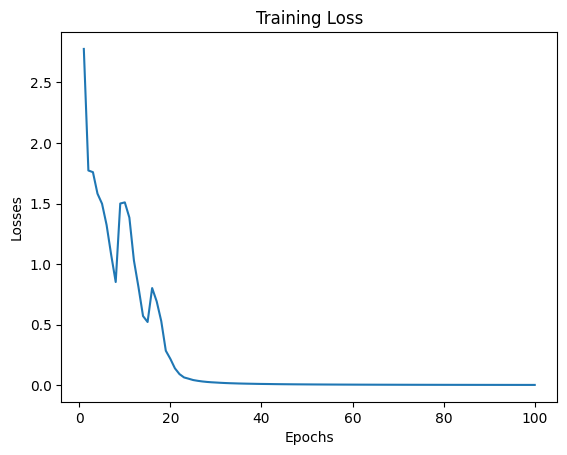

In [31]:
import matplotlib.pyplot as plt
epochs = range(1, len(history_loss)+1)

# Plot losses
plt.plot(epochs, history_loss)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss")
plt.show()

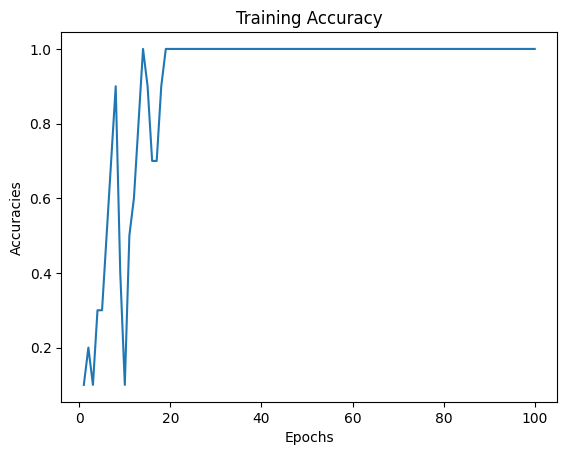

In [32]:
import numpy as np

# Plot epoch vs accuracy
history_acc = np.array([acc.cpu().numpy() for acc in history_acc])
plt.plot(epochs, history_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training Accuracy")
plt.show()

In [33]:
correct = 0
total = 0

with torch.no_grad(): # Disabling gradient calculation, since testing doesnot require weight update
    overfit_model.eval() # Set the model to evaluation mode

    for inputs, labels in overfit_loader:
      # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = overfit_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 50.00%


In [34]:
# Set the model to evaluation mode
model.eval()

# Iterate over the data loader
for images, labels in overfit_loader:

    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = overfit_model(images)
    _, predicted_indices = torch.topk(outputs, k=5, dim=1)

    # Print the true label and the top 5 predicted class indices
    print(f"True Label: {labels[0]}")
    print("Top 5 Predicted Class Indices:")
    for i, idx in enumerate(predicted_indices[0]):
        print(f"{i+1}. {idx.item()}")
    print("--------------------")

True Label: 2
Top 5 Predicted Class Indices:
1. 4
2. 2
3. 0
4. 9
5. 1
--------------------
True Label: 0
Top 5 Predicted Class Indices:
1. 9
2. 1
3. 4
4. 2
5. 0
--------------------
True Label: 1
Top 5 Predicted Class Indices:
1. 0
2. 4
3. 9
4. 1
5. 2
--------------------
True Label: 0
Top 5 Predicted Class Indices:
1. 0
2. 2
3. 4
4. 9
5. 1
--------------------
True Label: 4
Top 5 Predicted Class Indices:
1. 9
2. 2
3. 0
4. 4
5. 1
--------------------
True Label: 9
Top 5 Predicted Class Indices:
1. 9
2. 1
3. 0
4. 2
5. 4
--------------------
True Label: 9
Top 5 Predicted Class Indices:
1. 9
2. 1
3. 4
4. 2
5. 0
--------------------
True Label: 4
Top 5 Predicted Class Indices:
1. 1
2. 9
3. 4
4. 2
5. 0
--------------------
True Label: 1
Top 5 Predicted Class Indices:
1. 1
2. 2
3. 9
4. 4
5. 0
--------------------
True Label: 2
Top 5 Predicted Class Indices:
1. 2
2. 9
3. 0
4. 4
5. 1
--------------------


# Train on train_dataset of CIFAR-10

In [35]:
# Instantiate model
model_train = ResNet34(num_classes=10)

In [36]:
# Pass model to device
model_train = model_train.to(device)

In [37]:
# Compile the model
# Define the optimizer
optimizer = optim.Adam(model_train.parameters(), lr=0.0001) # Decrease the lr, because batch normalization

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [38]:
from tqdm import tqdm
import time

# Save train history
history_tl = []  # For epoch vs. loss
history_ta = [] # For epoch vs. accuracy

num_epochs = 5 # For less computation

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model_train.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    running_loss = 0.0
    running_corrects = 0

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_train(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Update running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1) # the maximum value and the index of that maximum value along dimension 1
        running_corrects += torch.sum(preds == labels.data) # labels.data gives access to underlying labels tensor

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Calculate epoch loss and accuracy for training data
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    history_tl.append(epoch_loss)
    history_ta.append(epoch_acc)

    # Print the loss and accuracy for training and validation data
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")


Epochs:  20%|██        | 1/5 [06:34<26:17, 394.36s/it]

Epoch 1 completed in 394.35 seconds
Epoch [1/5], Train Loss: 1.2252, Train Accuracy: 0.5573


Epochs:  40%|████      | 2/5 [13:05<19:36, 392.26s/it]

Epoch 2 completed in 390.78 seconds
Epoch [2/5], Train Loss: 0.7386, Train Accuracy: 0.7413


Epochs:  60%|██████    | 3/5 [19:36<13:03, 391.85s/it]

Epoch 3 completed in 391.36 seconds
Epoch [3/5], Train Loss: 0.5469, Train Accuracy: 0.8111


Epochs:  80%|████████  | 4/5 [26:08<06:31, 391.81s/it]

Epoch 4 completed in 391.72 seconds
Epoch [4/5], Train Loss: 0.4331, Train Accuracy: 0.8505


Epochs: 100%|██████████| 5/5 [32:39<00:00, 391.81s/it]

Epoch 5 completed in 390.78 seconds
Epoch [5/5], Train Loss: 0.3456, Train Accuracy: 0.8809


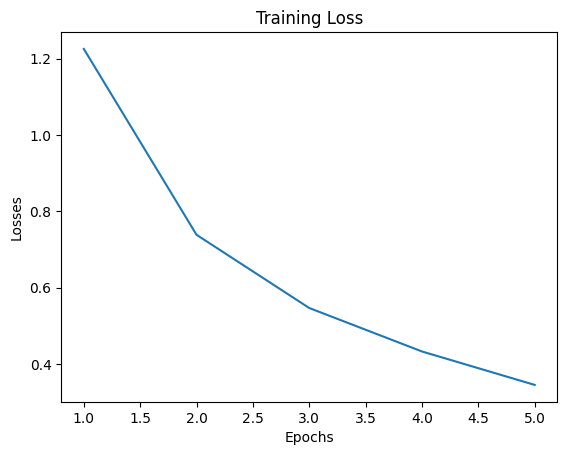

In [39]:
epochs = range(1, len(history_tl)+1)

# Plot losses
plt.plot(epochs, history_tl)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss")
plt.show()

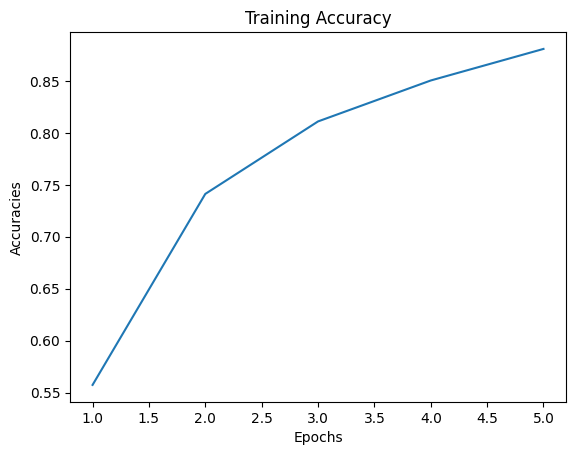

In [40]:
# Plot epoch vs accuracy
history_acc = np.array([acc.cpu().numpy() for acc in history_ta])
plt.plot(epochs, history_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training Accuracy")
plt.show()

# Test on test dataset of CIFAR-10

In [41]:
correct = 0
total = 0

with torch.no_grad(): # Disabling gradient calculation, since testing doesnot require weight update
    model_train.eval() # Set the model to evaluation mode

    for inputs, labels in test_loader:
      # Move the inputs and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_train(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 81.80%


In [42]:
# Visualize each image and predict its class

def predict_image(img):
  # Convert to a batch of 1
  xb = img.unsqueeze(0).to(device)
  # Get predictions from model
  yb = model_train(xb)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)

  return preds.item()

Actual Label:  ship (8)
Predicted Label:  ship (8)


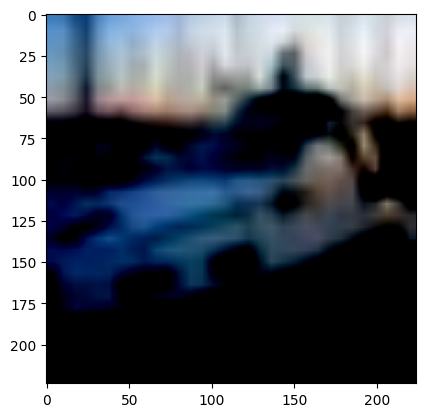

In [43]:
# For third image in dataset
img, label = test_dataset[2]
plt.imshow(img.permute(1,2,0))

predicted = predict_image(img)
print('Actual Label: ', test_dataset.classes[label], "("+str(label)+")")
print('Predicted Label: ', test_dataset.classes[predicted], "("+str(predicted)+")")

Actual Label:  deer (4)
Predicted Label:  deer (4)


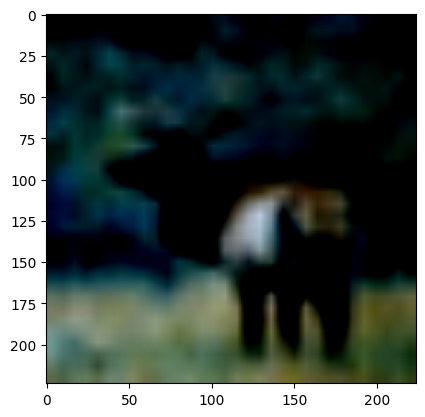

In [44]:
# For 1256th image in dataset
img, label = test_dataset[1255]
plt.imshow(img.permute(1,2,0))

predicted = predict_image(img)
print('Actual Label: ', test_dataset.classes[label], "("+str(label)+")")
print('Predicted Label: ', test_dataset.classes[predicted], "("+str(predicted)+")")